In [9]:
import scipy
import numpy as np
from tqdm import tqdm
from src.data import *
from src.utils import *
from src.main import *

import matplotlib.pyplot as plt
from sklearn.cluster import k_means

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils.extmath import randomized_svd
from sklearn.model_selection import train_test_split

In [11]:
cfg_weak = {
    "normalize":False,
    "size":1000,
    "weak_size":0.3,
    "beta":0.01,
    "gamma":0.01,
    "n_features":10,
    "n_clusters":3,
    "n_components_x":3,
    "n_components_y":4,
    "n_outputs_y":4,
    "noise_level_y":0.6,
    "repetitions":30,
}

In [12]:
tests_gaussian_singleoutput = {
    "weak":[],
    "train":[],
}

idxes_L_diag = []
k = 0
for i in range(2, cfg_weak["n_outputs_y"]+2):
    idxes_L_diag.append(k)
    k+=i
    
dictionary = tests_gaussian_singleoutput
for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )

    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_gaussian(X_full, normalize_W=cfg_weak["normalize"])

    L_full = L_full[:, idxes_L_diag]
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]

    L_star_single_weak = np.zeros_like(L_weak)
    L_star_single_weak[:, idxes_L_diag] = L_star_weak
    L_star_single_train = np.zeros_like(L_train)
    L_star_single_train[:, idxes_L_diag] = L_star_train
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_single_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_single_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))  
    
tests_gaussian_singleoutput = dictionary

Mean Train 1.856, Mean Weak 19.123: 100%|███████| 30/30 [00:02<00:00, 11.84it/s]


In [13]:
tests_kmeans_singleoutput = {
    "weak":[],
    "train":[],
}

idxes_L_diag = []
k = 0
for i in range(2, cfg_weak["n_outputs_y"]+2):
    idxes_L_diag.append(k)
    k+=i
    
dictionary = tests_kmeans_singleoutput
for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )

    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_k_means(X_full, n_clusters=cfg_weak["n_clusters"], normalize_W=cfg_weak["normalize"])

    L_full = L_full[:, idxes_L_diag]
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]

    L_star_single_weak = np.zeros_like(L_weak)
    L_star_single_weak[:, idxes_L_diag] = L_star_weak
    L_star_single_train = np.zeros_like(L_train)
    L_star_single_train[:, idxes_L_diag] = L_star_train
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_single_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_single_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))  
    
tests_kmeans_singleoutput = dictionary

Mean Train 0.764, Mean Weak 0.752: 100%|████████| 30/30 [00:04<00:00,  6.54it/s]


In [14]:
tests_kmeans_multioutput = {
    "weak":[],
    "train":[],
}

dictionary = tests_kmeans_multioutput
for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_k_means(X_full, n_clusters=cfg_weak["n_clusters"], normalize_W=cfg_weak["normalize"])
    
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_kmeans_multioutput = dictionary

Mean Train 0.125, Mean Weak 0.136: 100%|████████| 30/30 [00:04<00:00,  6.46it/s]


In [15]:
tests_gaussian_multioutput = {
        "weak":[],
        "train":[],
    }

dictionary = tests_gaussian_multioutput
for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_gaussian(X_full, normalize_W=cfg_weak["normalize"])
    
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_gaussian_multioutput = dictionary

Mean Train 1.156, Mean Weak 18.758: 100%|███████| 30/30 [00:02<00:00, 12.33it/s]


In [ ]:
plt.figure(figsize=(15, 7))
plt.suptitle('Wassestain distance\nResults after 50 random simulations')
ax1 = plt.subplot(121)
ax1.set_title("X_1")
ax1.boxplot([x["train"] for x in [tests_kmeans_singleoutput, tests_gaussian_singleoutput, tests_kmeans_multioutput, tests_gaussian_multioutput]],
           labels=["Not correalted\nKmeans Clustering \n3 clusters", "Not correalted\nGaussian", "Kmeans Clustering\n3 clusters", "Gaussian"])

ax2 = plt.subplot(122)
ax2.set_title("X_0")
ax2.boxplot([x["weak"] for x in [tests_kmeans_singleoutput, tests_gaussian_singleoutput, tests_kmeans_multioutput, tests_gaussian_multioutput]],
           labels=["Not correalted\nKmeans Clustering \n3 clusters", "Not correalted\nGaussian", "Kmeans Clustering\n3 clusters", "Gaussian"])

plt.show()

#### Sparse Solver

In [20]:
dictionary = {
        "weak":[],
        "train":[],
    }

for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_k_means(X_full, n_clusters=cfg_weak["n_clusters"], normalize_W=cfg_weak["normalize"])
    
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_kmeans_gt = dictionary

Mean Train 0.126, Mean Weak 0.139: 100%|████████| 30/30 [00:04<00:00,  6.37it/s]


In [21]:
dictionary = {
        "weak":[],
        "train":[],
    }
rank = 50

for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_k_means(X_full, n_clusters=cfg_weak["n_clusters"], normalize_W=cfg_weak["normalize"])
    
    u, s, vt = scipy.sparse.linalg.svds(W, k=rank)
    C_1, C_2 = u, np.diag(s)@vt
    D = np.diag(np.sum(W, axis=1))

    A_star, L_star = solve_sparse(D, C_1, C_2, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_kmeans_svd = dictionary

Mean Train 0.122, Mean Weak 0.133: 100%|████████| 30/30 [00:06<00:00,  4.35it/s]


In [22]:
dictionary = {
        "weak":[],
        "train":[],
    }
rank = 50
nystrom = Nystrom(rank)

for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_k_means(X_full, n_clusters=cfg_weak["n_clusters"], normalize_W=cfg_weak["normalize"])
    
    C_1_N, C_2_N = nystrom(W)
    D = np.diag(np.sum(W, axis=1))

    A_star, L_star = solve_sparse(D, C_1, C_2, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_kmeans_nystrom = dictionary

Mean Train 2.189, Mean Weak 2.889: 100%|████████| 30/30 [00:04<00:00,  6.90it/s]


In [23]:
dictionary = {
        "weak":[],
        "train":[],
    }
rank = 50

for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_k_means(X_full, n_clusters=cfg_weak["n_clusters"], normalize_W=cfg_weak["normalize"])
    u, s, vt = randomized_svd(W, n_components=rank, random_state=42)
    C_1, C_2 = u, np.diag(s)@vt
    D = np.diag(np.sum(W, axis=1))

    A_star, L_star = solve_sparse(D, C_1, C_2, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_kmeans_random_svd = dictionary

Mean Train 0.117, Mean Weak 0.128: 100%|████████| 30/30 [00:05<00:00,  5.10it/s]


In [24]:
dictionary = {
        "weak":[],
        "train":[],
    }

for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_gaussian(X_full, normalize_W=cfg_weak["normalize"])
    
    A_star, L_star = solve(W, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_gauss_gt = dictionary

Mean Train 1.179, Mean Weak 18.906: 100%|███████| 30/30 [00:02<00:00, 11.37it/s]


In [25]:
dictionary = {
        "weak":[],
        "train":[],
    }
rank = 50

for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_gaussian(X_full, normalize_W=cfg_weak["normalize"])
    
    u, s, vt = scipy.sparse.linalg.svds(W, k=rank)
    C_1, C_2 = u, np.diag(s)@vt
    D = np.diag(np.sum(W, axis=1))

    A_star, L_star = solve_sparse(D, C_1, C_2, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_gauss_svd = dictionary

Mean Train 1.140, Mean Weak 16.265: 100%|███████| 30/30 [00:12<00:00,  2.42it/s]


In [26]:
dictionary = {
        "weak":[],
        "train":[],
    }
rank = 50
nystrom = Nystrom(rank)

for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_gaussian(X_full, normalize_W=cfg_weak["normalize"])
    
    C_1_N, C_2_N = nystrom(W)
    D = np.diag(np.sum(W, axis=1))

    A_star, L_star = solve_sparse(D, C_1, C_2, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_gauss_nystrom = dictionary

Mean Train 1.178, Mean Weak 16.277: 100%|███████| 30/30 [00:02<00:00, 11.84it/s]


In [29]:
dictionary = {
        "weak":[],
        "train":[],
    }
rank = 50

for i in (pbar := tqdm(range(cfg_weak["repetitions"]))):
    means = np.concatenate([
                np.arange(cfg_weak["n_features"])[None, :] + 8*i
                for i in range(cfg_weak["n_components_x"])
            ])

    X, Y, A, L = make_monte_carlo(means,
                                  componenets_y=cfg_weak["n_components_y"],
                                  n_y=cfg_weak["n_outputs_y"],
                                  y_noise_level=cfg_weak["noise_level_y"]
                                 )
    X_train, X_weak, Y_train, Y_weak, A_train, A_weak, L_train, L_weak = train_test_split(X, Y, A, L, test_size=cfg_weak["weak_size"])
    X_full = np.concatenate([X_train, X_weak])
    Y_full = np.concatenate([Y_train, np.zeros_like(Y_weak)])
    A_full = np.concatenate([A_train, np.zeros_like(A_weak)])
    L_full = np.concatenate([L_train, np.zeros_like(L_weak)])
    B_full = np.diag(np.concatenate([np.ones(X_train.shape[0])*cfg_weak["beta"] + 1, np.ones(X_weak.shape[0])*cfg_weak["beta"]]))
    W = get_W_gaussian(X_full, normalize_W=cfg_weak["normalize"])
    
    u, s, vt = randomized_svd(W, n_components=rank, random_state=42)
    C_1, C_2 = u, np.diag(s)@vt
    D = np.diag(np.sum(W, axis=1))

    A_star, L_star = solve_sparse(D, C_1, C_2, B_full, Y_full, L_full)
    A_star_train, A_star_weak = A_star[:X_train.shape[0]], A_star[X_train.shape[0]:]
    L_star_train, L_star_weak = L_star[:X_train.shape[0]], L_star[X_train.shape[0]:]
    
    dictionary["weak"].append(get_Wasserstain(A_weak, L_weak, A_star_weak, L_star_weak))
    dictionary["train"].append(get_Wasserstain(A_train, L_train, A_star_train, L_star_train))
    pbar.set_description("Mean Train {:.3f}, Mean Weak {:.3f}".format(
        sum(dictionary["train"])/len(dictionary["train"]),
        sum(dictionary["weak"])/len(dictionary["weak"]),
    ))
    
tests_gauss_random_svd = dictionary

Mean Train 1.177, Mean Weak 19.079: 100%|███████| 30/30 [00:06<00:00,  4.98it/s]


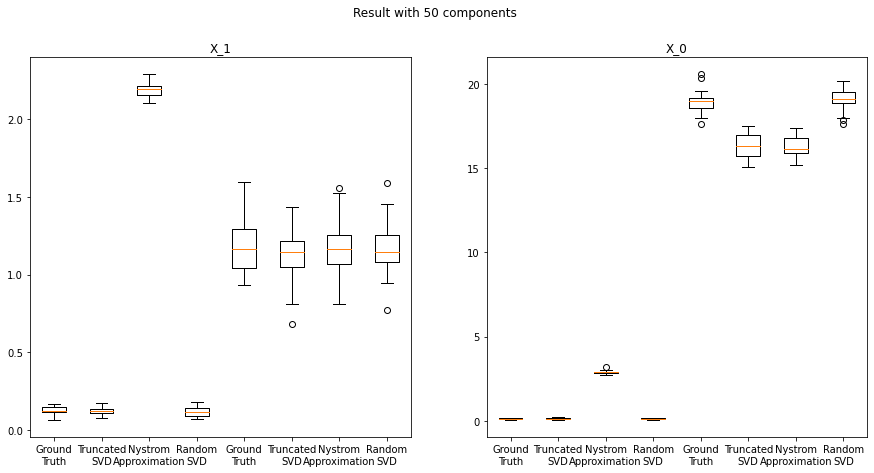

In [30]:
dicts = [
    tests_kmeans_gt,
    tests_kmeans_svd,
    tests_kmeans_nystrom,
    tests_kmeans_random_svd,
    tests_gauss_gt,
    tests_gauss_svd,
    tests_gauss_nystrom,
    tests_gauss_random_svd,
]

names = [
    "Ground\nTruth",
    "Truncated\nSVD",
    "Nystrom\nApproximation",
    "Random\nSVD",
    "Ground\nTruth",
    "Truncated\nSVD",
    "Nystrom\nApproximation",
    "Random\nSVD",
]

suptitle = 'Result with {} components'.format(rank)

plt.figure(figsize=(15, 7))
plt.suptitle(suptitle)
ax1 = plt.subplot(121)
ax1.set_title("X_1")
ax1.boxplot([x["train"] for x in dicts],
           labels=names)

ax2 = plt.subplot(122)
ax2.set_title("X_0")
ax2.boxplot([x["weak"] for x in dicts],
           labels=names)

plt.show()